Importing libraries

In [22]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [23]:
X_train = np.load(r"C:\Users\USER\TB-MLPipeline\preprocessed_data\X_train.npy")
X_test  = np.load(r"C:\Users\USER\TB-MLPipeline\preprocessed_data\X_test.npy")
y_train = np.load(r"C:\Users\USER\TB-MLPipeline\preprocessed_data\y_train.npy")
y_test  = np.load(r"C:\Users\USER\TB-MLPipeline\preprocessed_data\y_test.npy")

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes: (5088, 224, 224, 3) (1273, 224, 224, 3) (5088,) (1273,)


PNEUMONIA        3883
NORMAL           1349
TURBERCULOSIS     659
COVID19           470
Name: count, dtype: int64


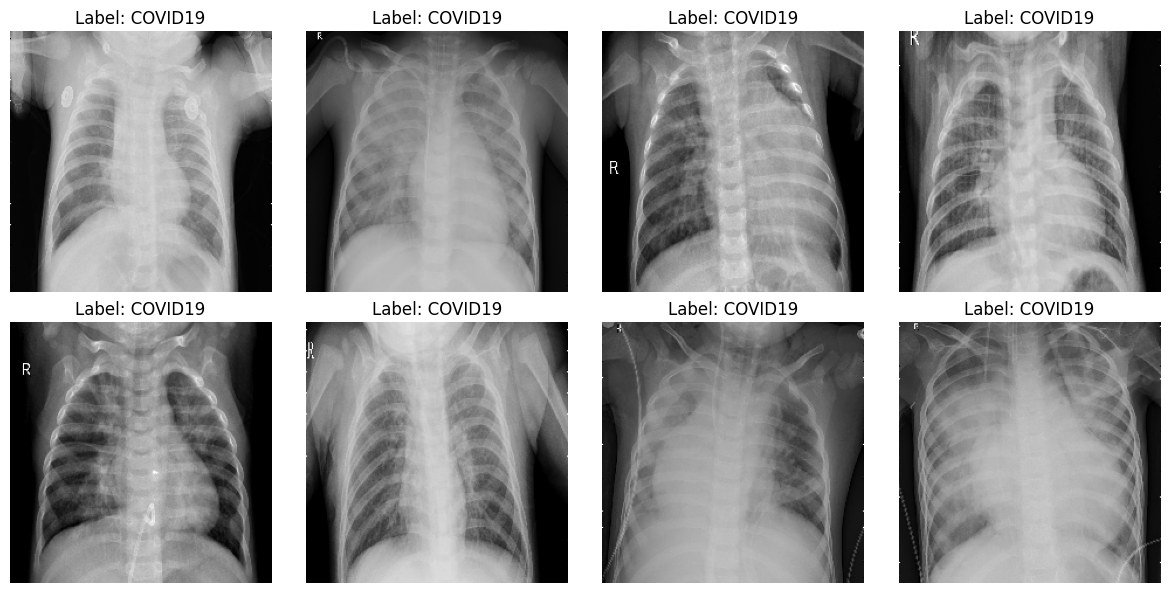

In [24]:
# Show number of images per class
import pandas as pd

class_counts = pd.Series(y).value_counts()
print(class_counts)

# Show sample images
fig, axes = plt.subplots(2, 4, figsize=(12,6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_train[i])
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


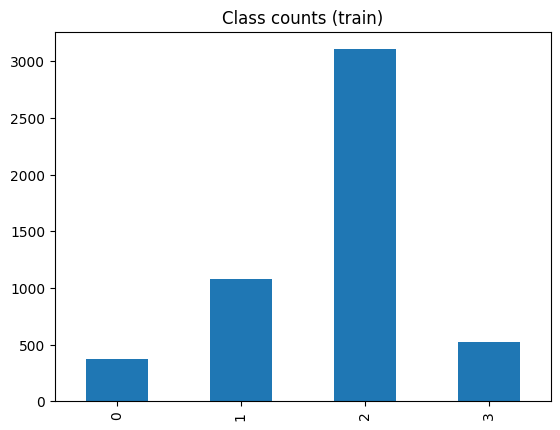

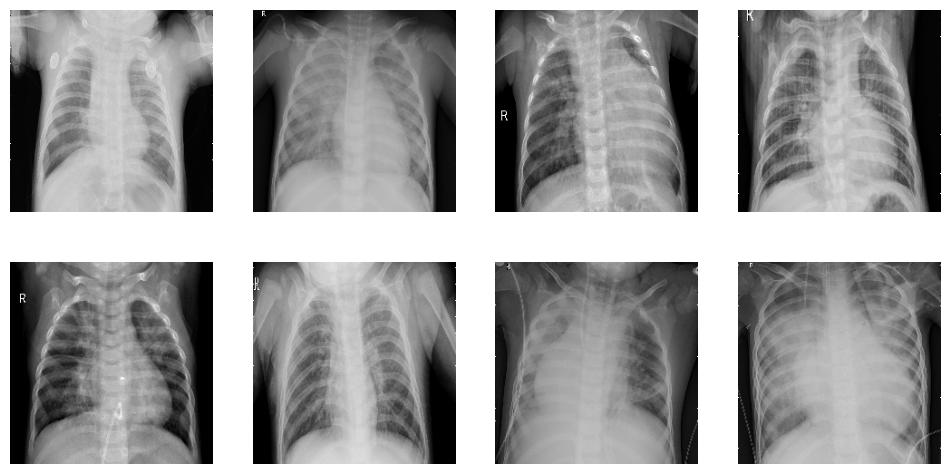

Text(0.5, 1.0, 'Pixel intensity histogram (sample)')

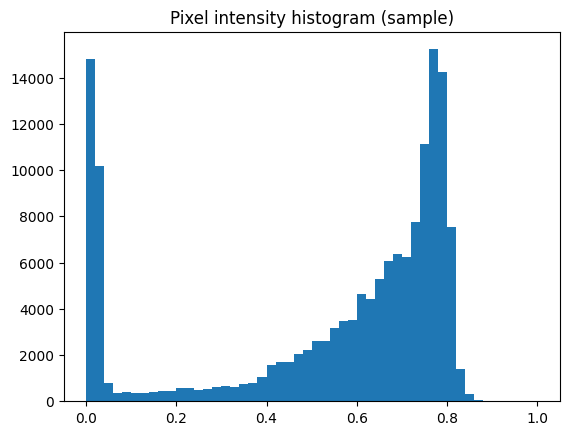

In [25]:
# 1) class distribution
import pandas as pd
pd.Series(y_train).value_counts().sort_index().plot(kind='bar', title='Class counts (train)')

# 2) sample images per class
from glob import glob
fig, axes = plt.subplots(2,4, figsize=(12,6))
axes = axes.flatten()
for i in range(8):
    axes[i].imshow(X_train[i])
    axes[i].axis('off')
plt.show()

# 3) pixel intensity histogram for random sample
plt.hist(X_train[0].ravel(), bins=50); plt.title("Pixel intensity histogram (sample)")


In [27]:
CLASS_INDEX_PATH = r"C:\Users\USER\TB-MLPipeline\preprocessed_data\class_indices.json"

with open(CLASS_INDEX_PATH, "r") as f:
    class_indices = json.load(f)

# reverse dict: index → label
index_to_label = {v: k for k, v in class_indices.items()}

num_classes = len(index_to_label)
print("Classes:", index_to_label)


Classes: {'COVID19': '0', 'NORMAL': '1', 'PNEUMONIA': '2', 'TURBERCULOSIS': '3'}


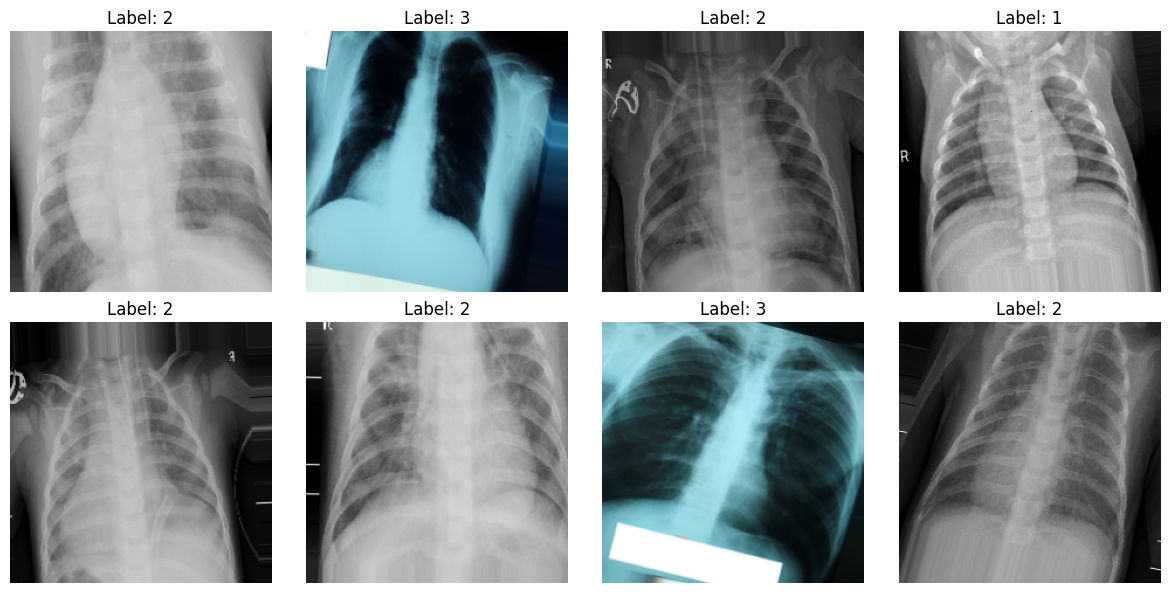

In [9]:
# Create augmentation generator
datagen = create_datagen()
datagen.fit(X_train)

# Example: show one augmented batch
for X_batch, y_batch in datagen.flow(X_train, y_train_cat, batch_size=8):
    fig, axes = plt.subplots(2,4, figsize=(12,6))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(X_batch[i])
        ax.set_title(f"Label: {np.argmax(y_batch[i])}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    break


Build the model

In [28]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=Adam(0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


c:\Users\USER\TB-MLPipeline\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [31]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # <-- change here
    metrics=['accuracy']
)

# Fit the model
history = model.fit(
    X_train, y_train,       # y_train stays as integers
    validation_split=0.2,
    epochs=15,
    batch_size=16
)


Epoch 1/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 148s 561ms/step - accuracy: 0.8494 - loss: 0.4318 - val_accuracy: 0.8880 - val_loss: 0.3279
Epoch 2/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 215s 618ms/step - accuracy: 0.9339 - loss: 0.1940 - val_accuracy: 0.9244 - val_loss: 0.2277
Epoch 3/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 162s 635ms/step - accuracy: 0.9477 - loss: 0.1532 - val_accuracy: 0.9391 - val_loss: 0.1839
Epoch 4/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 163s 639ms/step - accuracy: 0.9705 - loss: 0.0826 - val_accuracy: 0.9460 - val_loss: 0.2062
Epoch 5/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 158s 621ms/step - accuracy: 0.9848 - loss: 0.0516 - val_accuracy: 0.9509 - val_loss: 0.2427
Epoch 6/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 161s 631ms/step - accuracy: 0.9786 - loss: 0.0660 - val_accuracy: 0.9538 - val_loss: 0.3095
Epoch 7/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 159s 625ms/step - accuracy: 0.9818 - loss: 0.0499 - val_accuracy: 0.9460 - val_loss: 0.2918
Epoch 8/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 161s 633ms/step - accuracy: 0.9865 -

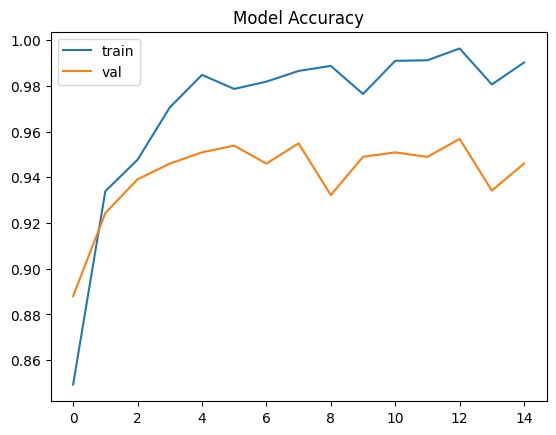

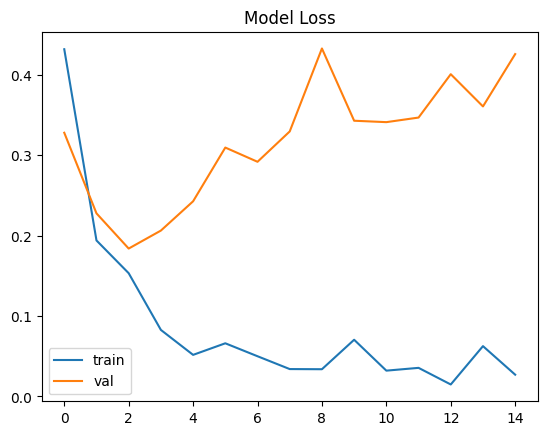

In [32]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.legend(["train","val"])
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.legend(["train","val"])
plt.show()


In [35]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(
    y_true,
    y_pred_classes,
    target_names=[index_to_label[i] for i in range(num_classes)]
))

cm = confusion_matrix(y_true, y_pred_classes)
print(cm)


40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [36]:
MODEL_PATH = r"C:\Users\USER\TB-MLPipeline\model\tb_cnn_model.h5"
model.save(MODEL_PATH)
print("Model saved at:", MODEL_PATH)


Model saved at: C:\Users\USER\TB-MLPipeline\model\tb_cnn_model.h5
